# <center>EAI Level User Interface
---

<small>*save a copy in a drive first!!*

In [ ]:
# For the first time run this
!ls
!pip install selenium 
!pip install selectorlib
!pip install scrapy
!pip install flask-ngrok
!pip install forex-python
!apt-get update
!apt install chromium-chromedriver 

# [Amazon Scraper](https://medium.com/analytics-vidhya/scraping-amazon-results-with-selenium-and-python-547fc6be8bfa) 

[search_result.yml](https://raw.githubusercontent.com/scrapehero-code/amazon-scraper/master/search_results.yml) >> click (open link) >> right click - save as >> upload to files

and add these lines after the price <br><br>

img_url: <br>
            css: 'div.a-section.a-spacing-none span.rush-component a.a-link-normal.s-no-outline div.a-section.aok-relative.s-image-fixed-height img.s-image' <br>
            xpath: null <br>
            type: Attribute <br>
            attribute: src <br>

In [ ]:
import numpy as np
import pandas as pd
import requests, json, time
from selectorlib import Extractor
from selenium import webdriver

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--incognito')

def search_amazon(item):
  driver = webdriver.Chrome('chromedriver',options=chrome_options)
  driver.get('https://www.amazon.com')
  search_box = driver.find_element_by_id('twotabsearchtextbox').send_keys(item)
  search_button = driver.find_element_by_id('nav-search-submit-text').click()

  driver.implicitly_wait(5)

  num_page = 7
  url_list = []

  for i in range(num_page):
      page_ = i + 1
      url_list.append(driver.current_url)
      driver.implicitly_wait(4)
      click_next = driver.find_element_by_class_name('a-last').click()
      print('Page ' + str(page_) + ' grabbed')

  driver.quit()

  with open('amazon_search_urls.txt', 'w') as filehandle:
      for result_page in url_list:
          filehandle.write('%s\n' % result_page)

  print('---DONE---\n')

def scrape(url):
  '''https://github.com/scrapehero-code/amazon-scraper'''
  headers = {
      'dnt': '1',
      'upgrade-insecure-requests': '1',
      'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36',
      'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
      'sec-fetch-site': 'same-origin',
      'sec-fetch-mode': 'navigate',
      'sec-fetch-user': '?1',
      'sec-fetch-dest': 'document',
      'referer': 'https://www.amazon.com/',
      'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
  }

  # Download the page using requests
  print('Downloading %s' %url)
  r = requests.get(url, headers=headers)
  # Simple check to check if page was blocked (Usually 503)
  if r.status_code > 500:
      if 'To discuss automated access to Amazon data please contact' in r.text:
          print('Page %s was blocked by Amazon. Please try using better proxies\n'%url)
      else:
          print('Page %s must have been blocked by Amazon as the status code was %d'%(url,r.status_code))
      return None
  # Pass the HTML of the page and create
  return e.extract(r.text)

search_amazon('refrigerator') # <------ search query goes here.

# Create an Extractor by reading from the YAML file
e = Extractor.from_yaml_file('search_results2.yml')

# product_data = []
with open('amazon_search_urls.txt','r') as urllist, open('amazon_output.jsonl','w') as outfile:
    for url in urllist.read().splitlines():
        data = scrape(url)
        if data:
            for product in data['products']:
                product['search_url'] = url
                # print("Saving Product: %s"%product['title'].encode('utf8'))
                json.dump(product,outfile)
                outfile.write('\n')
                # sleep(5)

Page 1 grabbed
Page 2 grabbed
Page 3 grabbed
Page 4 grabbed
Page 5 grabbed
Page 6 grabbed
Page 7 grabbed
---DONE---



In [ ]:
import json
import pandas as pd
 
asdf = []
with open('amazon_output.jsonl', 'r') as resl:
  for obj in resl.read().splitlines():
    asdf.append(json.loads(obj))

amazon_df = pd.DataFrame(asdf)
amazon_df['ref'] = 'amazon'

In [ ]:
amazon_df

,title,url,rating,reviews,price,img_url,search_url,ref
0,"FIZZEEY Mini Fridge with Freezer, Black - 3.2 ...",/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,None,None,$229.99,https://m.media-amazon.com/images/I/61seLn+S34...,https://www.amazon.com/s?k=refrigerator&ref=nb...,amazon
1,"FIZZEEY Mini Fridge with Freezer, Silver - 2.5...",/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,None,None,$177.97,https://m.media-amazon.com/images/I/61DlbqYfCg...,https://www.amazon.com/s?k=refrigerator&ref=nb...,amazon
2,RCA RFR322-B 3.2 Cu Ft Single Door Mini Fridge...,/RCA-RFR321-FR320-Refrigerator-Fridge-Stainles...,4.4 out of 5 stars,"10,242",$169.99,https://m.media-amazon.com/images/I/71Qo9QmlkY...,https://www.amazon.com/s?k=refrigerator&ref=nb...,amazon
3,Danby DPF073C1BSLDD Designer 7.3 cu.ft. Two Do...,/Danby-DPF073C1BSLDD-Designer-Apartment-Refrig...,3.9 out of 5 stars,128,$469.00,https://m.media-amazon.com/images/I/810ayB90Nx...,https://www.amazon.com/s?k=refrigerator&ref=nb...,amazon
4,Frigidaire FFTR1821TS 30 Inch Freestanding Top...,/Frigidaire-FFTR1821TS-Freestanding-Refrigerat...,3.8 out of 5 stars,59,None,https://m.media-amazon.com/images/I/41diQgqYuS...,https://www.amazon.com/s?k=refrigerator&ref=nb...,amazon
...,...,...,...,...,...,...,...,...
263,RCA RFR786-RED 2 Door Apartment Size Refrigera...,/RCA-RFR786-RED-Apartment-Refrigerator-Freezer...,4.0 out of 5 stars,121,None,https://m.media-amazon.com/images/I/614UMsIFOY...,https://www.amazon.com/s/?k=refrigerator&ref=s...,amazon
264,"Danby DAR044A6DDB 4.4 Cu.Ft. Mini Fridge, Comp...",/Danby-DAR044A6DDB-Contemporary-Classic-Refrig...,4.4 out of 5 stars,559,$289.00,https://m.media-amazon.com/images/I/81kvVO-YcA...,https://www.amazon.com/s/?k=refrigerator&ref=s...,amazon
265,Frigidaire FFTR1821TS 30 Inch Freestanding Top...,/Frigidaire-FFTR1821TS-Freestanding-Refrigerat...,3.8 out of 5 stars,59,None,https://m.media-amazon.com/images/I/41diQgqYuS...,https://www.amazon.com/s/?k=refrigerator&ref=s...,amazon
266,"FRIGIDAIRE, Stainless Steel FFSS2315TS 33 Inch...",/Frigidaire-FFSS2315TS-Refrigerator-Capacity-S...,4.0 out of 5 stars,80,None,https://m.media-amazon.com/images/I/51XXnZNNrM...,https://www.amazon.com/s/?k=refrigerator&ref=s...,amazon


# Ali Express Scraper

In [ ]:
import numpy as np
import pandas as pd
import requests, json, time, re
from selectorlib import Extractor
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--incognito')

base_url = 'https://www.aliexpress.com/af/refrigerator.html?trafficChannel=af&d=y&CatId=0&SearchText=refrigerator&ltype=affiliate&SortType=default&page='
with open('aliexpress_url.txt', 'w') as wrlx:
  for i in range(10):
    pg_num = i + 1
    wrlx.write(base_url + str(pg_num) + '\n')

def scrape(url):
  '''https://github.com/scrapehero-code/amazon-scraper'''

  # Download the page using requests
  print('Downloading %s' %url)
  driver = webdriver.Chrome('chromedriver',options=chrome_options)
  driver.get(url)

  soup = BeautifulSoup(driver.page_source, 'html.parser')
  driver.close()

  prod_list = []

  for i in range(60):
    product_items = soup.find_all('div', attrs={'product-index': i})
    if len(product_items) >0:
      for item in product_items:
        item_url = f"https:{item.find('a')['href']}"
        prod_list.append(item_url)
  return prod_list

def scrape_next(url):
  headers = {
      'dnt': '1',
      'upgrade-insecure-requests': '1',
      'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36',
      'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
      'sec-fetch-site': 'same-origin',
      'sec-fetch-mode': 'navigate',
      'sec-fetch-user': '?1',
      'sec-fetch-dest': 'document',
      'referer': 'https://best.aliexpress.com/?lan=en',
      'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
  }
  r = requests.get(url, headers=headers)
  # Simple check to check if page was blocked (Usually 503)
  if r.status_code > 500:
      if 'To discuss automated access to AliExpress data please contact' in r.text:
          print('Page %s was blocked by AliExpress. Please try using better proxies\n'%url)
      else:
          print('Page %s must have been blocked by AliExpress as the status code was %d'%(url,r.status_code))
      return None

  # Pass the HTML of the page and create
  target = ["title", "itemDetailUrl", "imagePath"]
  match = re.search(r'data: ({.+})', r.text).group(1)
  # print(match, '\n')
  # print(r.text)
  data = json.loads(match)
  # print(data, '\n')

  ready_alxp = dict()
  # if data.get([data['priceModule']['formatedActivityPrice']]):
  #   goal = [data['pageModule'][x] for x in target] + \
  #   [data['priceModule']['formatedActivityPrice']] + \
  #   [data['titleModule']['feedbackRating']['averageStar']] + \
  #   [data['titleModule']['feedbackRating']['trialReviewNum']]
  # else:
  ready_alxp['title'] = data['pageModule']['title']
  ready_alxp['url'] = data['pageModule']['itemDetailUrl']
  ready_alxp['img_url'] = data['pageModule']['imagePath']
  ready_alxp['price'] = data['priceModule']['formatedPrice']
  ready_alxp['rating'] = data['titleModule']['feedbackRating']['averageStar']
  ready_alxp['review'] = data['titleModule']['feedbackRating']['trialReviewNum']
  
  # print(goal, '\n')
  # print(e.extract(r.text))
  return ready_alxp

with open('aliexpress_url.txt','r') as urlin, open('prod_aliexp_url.txt', 'w') as wtrot:
  for url in urlin:
    dat_ls = scrape(url)
    for prd in dat_ls:
      wtrot.write(prd + '\n')

with open('prod_aliexp_url.txt','r') as urllist, open('output_search_aliexpress.jsonl','w') as outfile:
  for url in urllist.read().splitlines():
    data = scrape_next(url)
    print(data)
    if data:
      # print("Saving Product: %s"%data['title'].encode('utf8'))
      json.dump(data,outfile)
      outfile.write('\n')
      # sleep(5)

In [ ]:
bcgh = []
with open('output_search_aliexpress.jsonl', 'r') as resl:
  for obj in resl.read().splitlines():
    bcgh.append(json.loads(obj))

alxp_df = pd.DataFrame(bcgh)
alxp_df['ref'] = 'aliexpress'

In [ ]:
alxp_df

,title,url,img_url,price,rating,review,ref
0,Portable Freezer Fridge 12/24/220V 45W 20L/25L...,https://www.aliexpress.com/item/10050018174810...,https://ae01.alicdn.com/kf/Hb71e61414c4a4649a2...,US $252.67 - 307.12,5.0,0,aliexpress
1,Electric Refrige Fridge Warmer Cooler PC Refri...,https://www.aliexpress.com/item/32845778022.html,https://ae01.alicdn.com/kf/HTB1r1Z8bkSWBuNjSsz...,US $43.03,5.0,0,aliexpress
2,15 75 L Auto Mini Portable Car Refrigerator Ca...,https://www.aliexpress.com/item/10050023368150...,https://ae01.alicdn.com/kf/H4602206a26754beb98...,US $172.00 - 291.00,0.0,0,aliexpress
3,Portable Car Refrigerator Freezer Cooler 15L A...,https://www.aliexpress.com/item/10050023240502...,https://ae01.alicdn.com/kf/H199134f0f47749c19b...,US $178.24,0.0,0,aliexpress
4,12/24V 15L Auto Refrigerator 220V Car Home Min...,https://www.aliexpress.com/item/10050016673648...,https://ae01.alicdn.com/kf/H3bd907d298c94bc393...,US $151.78,5.0,0,aliexpress
...,...,...,...,...,...,...,...
75,【8L Mini Car Fridge】Travel Refrigerator Portab...,https://www.aliexpress.com/item/10050022894615...,https://ae01.alicdn.com/kf/H76f8f6390adc43f2b8...,US $210.00,0.0,0,aliexpress
76,Portable Car Fridge 55L Refrigerator Car Home ...,https://www.aliexpress.com/item/4000871195953....,https://ae01.alicdn.com/kf/Hd97674e9fdf6453b90...,US $394.00,0.0,0,aliexpress
77,25L 12V/24V Car Refrigerators Ultras Quiet Low...,https://www.aliexpress.com/item/4000856124249....,https://ae01.alicdn.com/kf/Hca27e7194fdb46efaa...,US $240.00,0.0,0,aliexpress
78,20L 12V 24V portable car refrigerator outdoor ...,https://www.aliexpress.com/item/4000678385579....,https://ae01.alicdn.com/kf/H6444e2a500364e2491...,US $220.00,0.0,0,aliexpress


# Preprocessing

In [ ]:
from forex_python.converter import CurrencyRates

def exchange_rate(price):
  '''USD to IDR'''
  c = CurrencyRates()

  exc_rate = c.get_rate('USD', 'IDR')
  return price * exc_rate

def rupiah_formatter(value):
  '''https://gist.github.com/yanwarsolah/77757781515110909c1077c914f26819'''
  str_value = str(float(value))
  separate_decimal = str_value.split(".")
  after_decimal = separate_decimal[0]
  before_decimal = separate_decimal[1]

  reverse = after_decimal[::-1]
  temp_reverse_value = ''

  for index, val in enumerate(reverse):
      if (index + 1) % 3 == 0 and index + 1 != len(reverse):
          temp_reverse_value = temp_reverse_value + val + "."
      else:
          temp_reverse_value = temp_reverse_value + val

  temp_result = temp_reverse_value[::-1]

  return 'Rp ' + temp_result + ',' + before_decimal + str(0)

In [ ]:
alxp_df.isna().sum().sum()

0

In [ ]:
alxp_df['rating'] = alxp_df['rating'].astype('float')
alxp_df['review'] = alxp_df['review'].astype('int')
alxp_df['title'] = alxp_df.title.apply(lambda x: x[:-12].strip().split('|')[0])

pr_up = alxp_df.price.apply(lambda x: float(x.split()[3][1:-3].replace(',', '.')) if len(x.split()) == 4 else 0).apply(exchange_rate)
pr_dn = alxp_df.price.apply(lambda x: float(x.split()[1][1:-3].replace(',', '.'))).apply(exchange_rate)
alxp_df['price_num'] = (round((pr_up + pr_dn) / 2)).astype('int')
alxp_df['price'] = (round((pr_up + pr_dn) / 2)).astype('int')
alxp_df['price'] = alxp_df['price'].apply(rupiah_formatter)

alxp_df = alxp_df.loc[:, ['title', 
                          'url',
                          'rating',
                          'review',
                          'price',
                          'img_url',
                          'ref',
                          'price_num']]

In [ ]:
amazon_df.head(1)

,title,url,rating,reviews,price,img_url,search_url,ref
0,"FIZZEEY Mini Fridge with Freezer, Black - 3.2 ...",/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,None,None,$229.99,https://m.media-amazon.com/images/I/61seLn+S34...,https://www.amazon.com/s?k=refrigerator&ref=nb...,amazon


In [ ]:
amazon_df.isna().sum()

title           0
url             0
rating         12
reviews        12
price           7
img_url       180
search_url      0
ref             0
dtype: int64

In [ ]:
amazon_df = amazon_df[(amazon_df.img_url.notna()) & (amazon_df.price.notna())]
amazon_df = amazon_df.fillna(0)
amazon_df = amazon_df.drop('search_url', axis=1).reset_index(drop=True)

In [ ]:
amazon_df.isna().sum().sum()

0

In [ ]:
amazon_df['price'] = round(amazon_df.price.apply(lambda x: float(x[1:].replace(',', ''))).apply(exchange_rate)).astype('int')
amazon_df['rating'] = amazon_df['rating'].apply(lambda x: float(x[:3]) if x!=0 else float(x))
amazon_df['url'] = amazon_df.url.apply(lambda x: 'https://www.amazon.com' + x)
amazon_df['reviews'] = amazon_df['reviews'].apply(lambda x: int(str(x).replace(',', '')))
amazon_df['price_num'] = amazon_df['price']
amazon_df['price'] = amazon_df['price'].apply(rupiah_formatter)

alxp_df.columns = amazon_df.columns

In [ ]:
full_df = pd.concat([alxp_df, amazon_df]).sample(frac=1).reset_index(drop=True)
full_df = full_df.sort_values(by=['rating', 'reviews'], ascending=False).reset_index(drop=True)
full_df

,title,url,rating,reviews,price,img_url,ref,price_num
0,"Frigidaire EFR451 2 Door Refrigerator/Freezer,...",https://www.amazon.com/Frigidaire-EFR451-Refri...,3.9,320,"Rp 4.034.489,00",https://m.media-amazon.com/images/I/510HNxTK7b...,amazon,4034489
1,Danby DPF073C1BSLDD Designer 7.3 cu.ft. Two Do...,https://www.amazon.com/Danby-DPF073C1BSLDD-Des...,3.9,128,"Rp 6.774.706,00",https://m.media-amazon.com/images/I/810ayB90Nx...,amazon,6774706
2,Electric Refrige Fridge Warmer Cooler PC Refri...,https://www.aliexpress.com/item/32845778022.html,5.0,0,"Rp 310.568,00",https://ae01.alicdn.com/kf/HTB1r1Z8bkSWBuNjSsz...,aliexpress,310568
3,CURTIS MIS135DRP DR. Pepper Mini Portable Comp...,https://www.amazon.com/CURTIS-MIS135DRP-Portab...,5.0,3,"Rp 418.905,00",https://m.media-amazon.com/images/I/81g5huqxE0...,amazon,418905
4,20L Car Refrigerator 5~65 Degrees Cooler Car ...,https://www.aliexpress.com/item/10050020942837...,0.0,0,"Rp 1.307.273,00",https://ae01.alicdn.com/kf/Hcb0a462b61b74733ad...,aliexpress,1307273
...,...,...,...,...,...,...,...,...
156,10L Small Refrigerator 12V 24VCar Home Dual us...,https://www.aliexpress.com/item/4001140000214....,4.7,0,"Rp 245.565,00",https://ae01.alicdn.com/kf/H14ccdf084e0e47ce89...,aliexpress,245565
157,BLACK+DECKER BCRK32B Compact Refrigerator Ener...,https://www.amazon.com/BLACK-DECKER-BCRK32B-Co...,4.6,807,"Rp 2.426.616,00",https://m.media-amazon.com/images/I/413C303V4n...,amazon,2426616
158,55L Car Auto AC/DC12/24V Portable Compressor C...,https://www.aliexpress.com/item/10050023132051...,0.0,0,"Rp 3.813.480,00",https://ae01.alicdn.com/kf/He2a7946aeda3419d86...,aliexpress,3813480
159,"Frigidaire EFR451 2 Door Refrigerator/Freezer,...",https://www.amazon.com/Frigidaire-EFR451-Refri...,3.9,320,"Rp 4.034.489,00",https://m.media-amazon.com/images/I/510HNxTK7b...,amazon,4034489


In [ ]:
# clean output
# full_df.to_json('clean_all_scrape.json', orient='records')
import json
with open('clean_all_scrape.json', 'r') as resl:
  for xpp in resl.read().splitlines():
    clmzxp = json.loads(xpp)

clmzxp[:3]

[{'img_url': 'https://m.media-amazon.com/images/I/81RdeX-olwL._AC_UY218_.jpg',
  'price': 'Rp 7.222.356,00',
  'price_num': 7222356,
  'rating': 5.0,
  'ref': 'amazon',
  'reviews': 7,
  'title': 'Antarctic Star 15 Inch Beverage Refrigerator Buit-in Wine Cooler Mini Fridge Clear Glass Door Digital Memory Temperature Control, Beer Soda LED Light, Quiet Operation (15 Inch)',
  'url': 'https://www.amazon.com/gp/slredirect/picassoRedirect.html/ref=pa_sp_mtf_aps_sr_pg1_1?ie=UTF8&adId=A0491481XIP425SLZFT&url=%2FAntarctic-Star-Refrigerator-Temperature-Operation%2Fdp%2FB08G8R3LT7%2Fref%3Dsr_1_17_sspa%3Fdchild%3D1%26keywords%3Drefrigerator%26pd_rd_r%3Db0c26477-1be2-45ec-b6a0-d2368d63c5a0%26pd_rd_w%3DQaSVr%26pd_rd_wg%3DFoUmI%26pf_rd_p%3D4fa0e97a-13a4-491b-a127-133a554b4da3%26pf_rd_r%3DY78QCX94E1Q4SAYJNBNV%26qid%3D1617018171%26sr%3D8-17-spons%26psc%3D1&qualifier=1617018171&id=4413353091377602&widgetName=sp_mtf'},
 {'img_url': 'https://m.media-amazon.com/images/I/81g5huqxE0L._AC_UY218_.jpg',
  'pr

# Web UI

In [ ]:
error_404 = '''
<div style="position: fixed;top: 50%;left: 50%;transform: translate(-50%, -50%);">
  <h1>Page Not Found!!</h1>
  <p><a href="{{ url_for('index') }}">Back</a></p>
</div>
'''

error_500='''
<div style="position: fixed;top: 50%;left: 50%;transform: translate(-50%, -50%);">
  <h1>An unexpected error has occurred</h1>
  <p>The administrator has been notified. Sorry for the inconvenience!</p>
  <p><a href="{{ url_for('index') }}">Back</a></p>
</div>
'''

index_html='''
<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">

    {% if title %}
    <title>{{ title }} - E-Store</title>
    {% else %}
    <title>E-Store</title>
    {% endif %}

    <link rel="shortcut icon" href="https://www.vhv.rs/dpng/d/118-1187671_ice-clipart-hielo-ice-icon-png-transparent-png.png" type="image/x-icon">
    <link rel="icon" href="https://www.vhv.rs/dpng/d/118-1187671_ice-clipart-hielo-ice-icon-png-transparent-png.png" type="image/x-icon">
    
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta3/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-eOJMYsd53ii+scO/bJGFsiCZc+5NDVN2yr8+0RDqr0Ql0h+rP48ckxlpbzKgwra6" crossorigin="anonymous">
    
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
    <link rel="stylesheet" href="https://use.fontawesome.com/releases/v5.15.1/css/all.css">
    <link rel="stylesheet" href="https://use.fontawesome.com/releases/v5.15.1/css/v4-shims.css">
  </head>
  <body style="background-color: aliceblue">
    <nav class="navbar navbar-dark bg-dark">
      <div class="container">
        <div class="text-white">
          <a class="nav-link active mr-auto" href="/">
            <i class="fas fa-home" style="width:35;height:35;color:white;"></i>
          </a>
        </div>
        <div class="justify-content-center">
          <a class="navbar-brand" href="/">
            Refrigerator
          </a>
        </div>
        <div class="justify-content-end text-white">
          <a class="nav-link active ml-auto" href="/cart">
            <i class="fas fa-shopping-cart" style="width:35;height:35;color:white;"></i>
          </a>
        </div>
      </div>
    </nav>

    <!-- Content -->
    <div class="container pt-5">
      <div class="row">
        {% for refri in datae %}
        <div class="col-md-3 pt-4">
          <a class="card rounded-lg text-dark" href="{{ refri.url }}" data-toggle="tooltip" data-placement="top" title="{{ refri.price }}" style="height: 28em; box-shadow: rgba(0, 0, 0, 0.8) 0px 7px 10px, inset rgba(0, 0, 0, 0.15) 0px 0px 3px; text-decoration: none;" id="card-table">

              <img src="{{ refri.img_url }}" class="card-img-top" style="height: 12em;">

              <div class="card-body text-center py-0" data-toggle="tooltip" data-placement="top" title="{{ refri.title }}">
                  <h5 class="card-title mt-1">{{ refri.title[:70] }}...</h5>
              </div>
              <div class="card-footer bg-white pt-2 px-0">
                  <div class="row pr-0 pl-2 pt-0 pb-1">
                      <div class="col-md-1 px-0"></div>
                      <div class="col-md-1 pr-0 pl-1 text-right" style="color:orange;">
                          <i class="fas fa-star"></i>
                      </div>
                      <div class="col-md-2 pl-1 pr-2 text-left" data-toggle="tooltip" data-placement="top" title="{{ refri.rating }} out of 5.0">
                        {{ refri.rating }}
                      </div>
                      <div class="col-md-1 pl-2 pr-0 text-right text-black-50 ">
                          <i class="fas fa-briefcase"></i>
                      </div>
                      <div class="col-md-3 pl-1 pr-0 text-left text-black-50">
                          {{ refri.ref }}
                      </div>
                      <div class="col-md-1 text-right pr-0 pl-0 text-black-50">
                          <i class="fas fa-user-check"></i>
                      </div>
                      <div class="col-md-2 pl-1 pr-2 text-left" data-toggle="tooltip" data-placement="top" title="{{ refri.reviews }} user reviews">
                          {{ refri.reviews }}
                      </div>
                  </div>
              </div>
              <div class="card-footer bg-white text-center">
                  <div class="col-md-12 px-0">
                    <h5> {{ refri.price }} </h5>
                  </div>
              </div>
          </div></a>
          {% endfor %}
      </div>
    </div>

    <script src="https://cdn.jsdelivr.net/npm/@popperjs/core@2.9.1/dist/umd/popper.min.js" integrity="sha384-SR1sx49pcuLnqZUnnPwx6FCym0wLsk5JZuNx2bPPENzswTNFaQU1RDvt3wT4gWFG" crossorigin="anonymous"></script>
    <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta3/dist/js/bootstrap.min.js" integrity="sha384-j0CNLUeiqtyaRmlzUHCPZ+Gy5fQu0dQ6eZ/xAww941Ai1SxSY+0EQqNXNE6DZiVc" crossorigin="anonymous"></script>

    <script defer src="https://use.fontawesome.com/releases/v5.15.1/js/all.js"></script>
    <script defer src="https://use.fontawesome.com/releases/v5.15.1/js/v4-shims.js"></script>
  </body>
  
</html>

'''

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import render_template_string
from flask import Flask
# from OpenSSL import SSL
# context = SSL.Context(SSL.PROTOCOL_TLSv1_2)
# context.use_privatekey_file('server.key')
# context.use_certificate_file('server.crt') 

app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run

@app.route('/')
@app.route('/index')
def index():
  THE_DATA = clmzxp
  return render_template_string(index_html, title='Big Sale', datae=THE_DATA)

@app.errorhandler(404)
def not_found_error(error):
    return render_template_string(error_404), 404

@app.errorhandler(500)
def internal_error(error):
    # db.session.rollback()
    return render_template_string(error_500), 500

if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://9c87e800322e.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [01/Apr/2021 09:29:37] "GET / HTTP/1.1" 200 -


# Result

Saving eai.png to eai.png
User uploaded file "eai.png" with length 786820 bytes


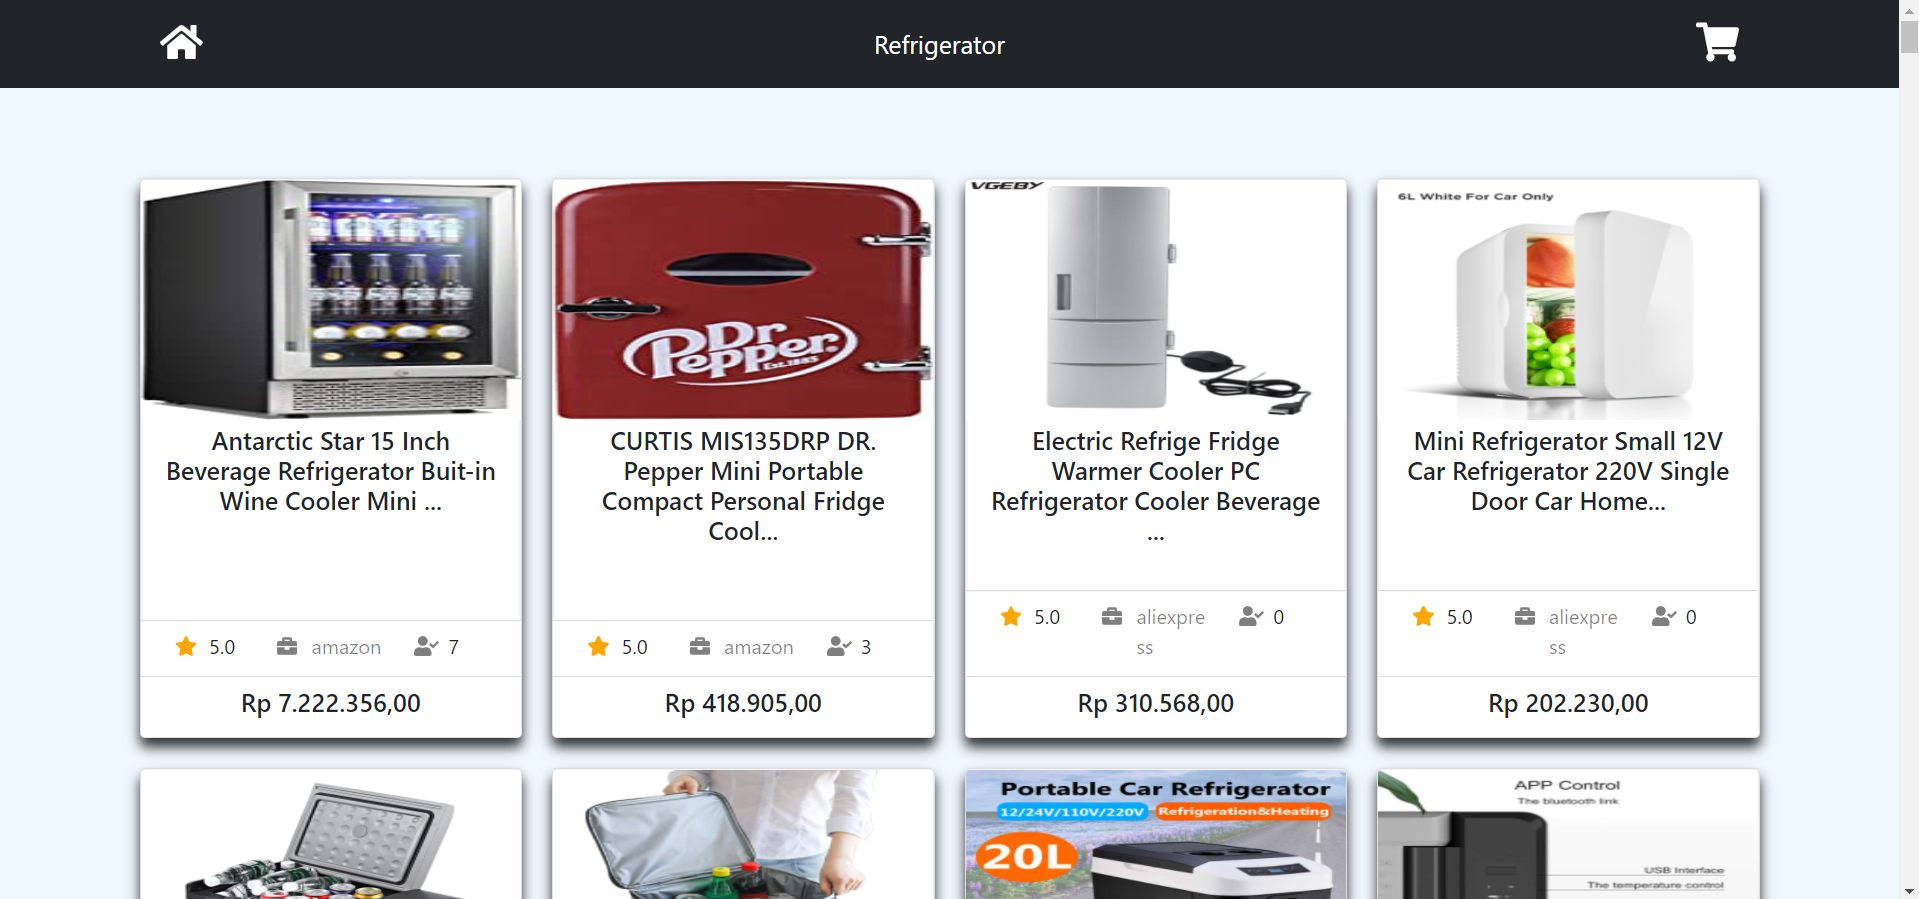

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
img = cv2.imread(fn, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)